# 1. Analysis objectives
This analysis is focused on dimensionality reduction of an image dataset. Large image datasets may use a substantial amount of storage space so it can be beneficial to compress the images if enough useful image information can be retained. 

The objective of this analysis is to compare several dimensionality reduction techniques to see which can retain the most information for a given amount of compression. If most of the image information could be retained, the dataset could potentially be compressed with one of the methods tested.

# 2. Data summary and modelling process
The dataset can be found here:
https://www.kaggle.com/datasets/alessiocorrado99/animals10 <BR>
It contains 26179 image files in jpeg, jpg or png format. <BR>
The files are of a medium quality, with the total size of the dataset equal to 585 MB. <BR>
    
Images of 10 different animal species are contained in the dataset: dog, cat, horse, spider, butterfly, chicken, sheep, cow, squirrel, elephant. <BR>
    
We will compare several dimensionality reduction techniques to see which can retain the most information for the dataset for a given amount of compression. The metric we will use is mean squared error which is calculated on the pixel intensity values, which have a value in the range (0, 255). 3 dimensionality reduction models will be tested:<BR>
1. Principal Component Analysis (PCA)
2. Non-Negative Matrix Factorisation (NMF)
3. Kernel PCA
    
The process will be as follows:
* Randomly select 100 images from the dataset
* Divide the image into sections, with each section containing 10 x 10 pixels
* The number of observations in our model is therefore the number of sections and the number of features are the 100 pixels in each section multiplied by 3 (R,G and B values for each pixel) 
* Fit models for various n_components on each of the 100 images
* Find the inverse transform of each model to recreate the original image
* Calculate the mean squared error of each inverse transform versus the original image
* Calcuate the mean error across the 100 images, for each n_component
 
    

# 3. Data exploration
As we are dealing with image data here, there is no particular data cleaning or feature engineering required. We are not particularly concerned with what each image represents, just how we can compress the image while maintaining image information.  

As we are dealing with image data here, we will be looking at the R, G, B intensity values for each pixel. We will convert these pixel values from a range of 0 to 255 to a range of 0 to 1 for input into our machine learning models.  

In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import random
from sklearn.decomposition import PCA
from sklearn.decomposition import NMF
from sklearn.decomposition import KernelPCA
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

Filepath for image data:

In [2]:
filepath = r'data\raw-img'

Function to generate a list of image files from the filepath:

In [16]:
def generate_image_list(filepath):
    '''
    Returns a list of filepaths for 100 images that match the image format and dimension criteria
    '''
    # Image formats to read
    ext = ['jpg', 'jpeg']    
    # Extract a list of image files
    img_list = []
    for fname in [glob.glob(filepath + '\*\*.' + i) for i in ext]:
        img_list.append(fname)
    # Flatten the list
    img_list = [i for sublist in img_list for i in sublist]
    # Open each image
    img_list2 = []
    for i in img_list:
        img = Image.open(i)
        width, height = img.size
        # For simplicity, only slect from images with pixel dimensions
        # divisible by 10
        if (width % 10 == 0 and height % 10 == 0):
            img_list2.append(i)
    # Return 100 randomly selected images
    return random.choices(img_list2, k=100)

Generate the list of images:

In [17]:
image_list = generate_image_list(filepath)

# 4. Unsupervised learning models

To perform the PCA we will divide the image into sections. Eg, a 300 x 200 pixel image will be divided into 30 x 20 sections, each containing 100 pixels from the original image. In this example each of these 600 sections represents an observation and each observation will have 100 * 3 features. The number of pixels is multiplied by 3 as each pixel has an R, G and B value.

This data is converted into dataframe format and input into our dimension reduction models. We will test 3 different models: Principal Component analysis (PCA), non-negative matrix factorisation (NMF) and PCA with Kernel approximation (Kernel PCA).



Define some functions:

In [5]:
def section_image(image_file):
    '''
    Reads in an image file, divides it into sections and converts to a dataframe where the rows represent
    each of the sections and the columns contain all of the pixel data for each section.
    '''
    width, height = image_file.size
    img = np.asarray(image_file)
    # Each section will contain px_per_section * px_per_section pixels
    px_per_section = 10
    # Section dimensions in x and y
    rows = int(np.floor(height / px_per_section))
    cols = int(np.floor(width / px_per_section))
    # Divide the image into sections. Set each row of the dataframe to represent one section. 
    # Each row is a flattened array of the R,G and B pixel values of each section
    df=pd.DataFrame()
    for row in range(rows):
        for col in range(cols):
            data = img[px_per_section*row:px_per_section*(row+1), px_per_section*col:px_per_section*(col+1), :].ravel()
            df = pd.concat([df,pd.Series(data)], axis=1)
    # Transpose so the rows reflect the pixels in the compressed image
    # Divide by 255 so all values are between 0 and 1
    df = df.T/255
    return df, width, height

In [6]:
def pca_model(image_file, n_components):
    '''
    Fits a PCA model to an image then calculates the inverse transform to recreate the original image using the 
    Principal components. Reshape the array to the shape of the original image
    '''
    # Section the image
    dataframe, width, height = section_image(image_file)
    rows = int(np.floor(height / px_per_section))
    cols = int(np.floor(width / px_per_section))
    # Initialise and fit the model
    pca = PCA(n_components=n_components)
    pca.fit(dataframe)
    img_pca = pca.transform(dataframe)
    img_inverse = pca.inverse_transform(img_pca)
    #img_inverse = np.array(pd.DataFrame(img_inverse)).ravel().reshape(width*height, 3).reshape(600,100,3)
    img_inverse = np.array(pd.DataFrame(img_inverse)).ravel().reshape(rows*cols, px_per_section*px_per_section, 3)
    array= return_array(img_inverse, width, height)
    return array

In [7]:
def nmf_model(image_file, n_components):
    '''
    Fits a NMF model to an image then calculates the inverse transform to recreate the original image using the 
    Principal components. Reshape the array to the shape of the original image
    '''
    # Section the image
    dataframe, width, height = section_image(image_file)
    rows = int(np.floor(height / px_per_section))
    cols = int(np.floor(width / px_per_section))
    # Initialise and fit the model
    nmf = NMF(n_components=n_components, init='random', max_iter=2000)
    W = nmf.fit_transform(dataframe)
    H = nmf.components_
    img_inverse = np.dot(W,H).reshape(rows*cols, px_per_section*px_per_section, 3)
    array= return_array(img_inverse, width, height)
    return array

In [84]:
def kernel_pca_model(image_file, n_components):
    '''
    Fits a Kernel PCA model to an image then calculates the inverse transform to recreate the original image using the 
    Principal components. Reshape the array to the shape of the original image
    '''
    # Section the image
    dataframe, width, height = section_image(image_file)
    rows = int(np.floor(height / px_per_section))
    cols = int(np.floor(width / px_per_section))
    # Initialise and fit the model
    kpca = KernelPCA(n_components=n_components, kernel='rbf', gamma=0.1, fit_inverse_transform=True)
    kpca.fit(dataframe)
    img_pca = kpca.transform(dataframe)
    img_inverse = kpca.inverse_transform(img_pca)
    #img_inverse = np.array(pd.DataFrame(img_inverse)).ravel().reshape(width*height, 3).reshape(600,100,3)
    img_inverse = np.array(pd.DataFrame(img_inverse)).ravel().reshape(rows*cols, px_per_section*px_per_section, 3)
    array= return_array(img_inverse, width, height)
    return array

In [88]:
def return_array(img_inverse, width, height):
    '''
    Takes an array recreated from Principal components and reshapes it into the original image dimensions
    '''
    rows = int(height / px_per_section)
    cols = int(width / px_per_section)
    # Rearrange the pixels in each sections to reform the original image  
    arr = np.empty((0,3), int) #initialise an empty array
    #for k in range(0, rows*cols, cols+1):
    for k in range(0, rows*cols, cols):
        for j in range(px_per_section):
            for i in range(cols):
                arr = np.append(arr, img_inverse[i+k, px_per_section*j:px_per_section*(j+1), :], axis=0)

    # reshape to the original image dimensions
    arr = arr.reshape(height, width, 3) * 255
    return arr

* Fit a PCA, NMF and Kernel PCA model to each of the 100 images in the image list and for various n_components values
* Calculate the mean squared error for each model
* Calculate the average error for each set of 100 models

In [ ]:
n_components = [3, 5, 10, 20, 50, 100]
px_per_section = 10
models = {'PCA': pca_model, 'NMF': nmf_model, 'Kernel_PCA': kernel_pca_model}

# A list of dataframes
errors_list = []
for key, model in models.items():
    # Dataframe rows = n_components, columns = images
    df = pd.DataFrame() 
    for file in image_list:
        image = Image.open(file)
        errors = [mean_squared_error(np.asarray(image).ravel(), model(image, n).ravel()) for n in n_components]
        df = pd.concat([df, pd.Series(errors)], axis=1)
    df.index=n_components
    errors_list.append(df)

Select a random image and plot the recreated image for various n_components values to visually show the effect of increasing the number of components

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


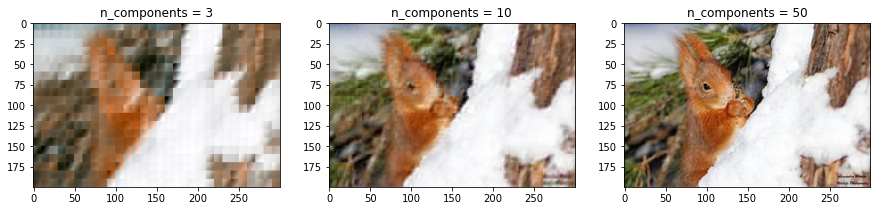

In [85]:
image = Image.open(image_list[85])
n_components = [3, 10, 50]
fig = plt.figure(figsize=(15,30))

for i, n in enumerate(n_components):
    arr = pca_model(image, n)
    fig.add_subplot(1,3,i+1)
    plt.imshow(arr/255)
    plt.title('n_components = {}'.format(n))
plt.show()

Plot the mean squared error in the pixel values for the different n_components values 

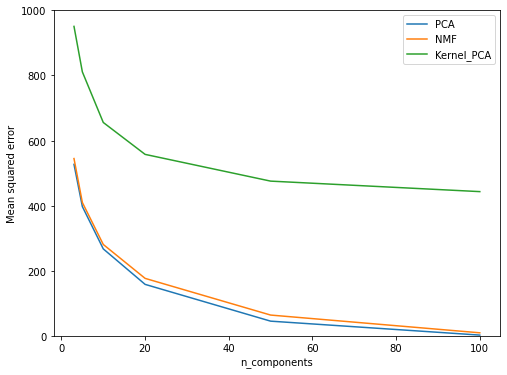

In [86]:
plt.figure(figsize=(8,6))
for i, model in enumerate(models.items()):
    plt.plot(errors_list[i].mean(axis=1), label=model[0])
plt.xlabel('n_components')
plt.ylabel('Mean squared error')
plt.ylim(0,1000)
plt.legend()
plt.show()

# 5. Recommendations 
The PCA model had the lowest mean squared error for all n_components out of the 3 models tested, so this is recommended as the best model for compressing images in this dataset.

# 6. Key findings
* The PCA model had the lowest error out of the models tested
* The Kernel PCA model had much poorer performance than the other 2 models
* The error reduces rapidly as the number of components increases. For 100 n_components, the mean squared error in the pixel values is quite small.

# 7. Next steps
* The PCA model explains the variance in the images quite well, suggesting that a Kernel PCA model, which is better for non-linear relationships, may not be neccessary and not particularly well suited to this image data. 
* Some default hyperparameters were used in the Kernel PCA model and hyperparameter tuning may be able to improve the model performance.
* Instead of fitting a single model for each image, a separate model could be fitted to the R, G and B pixel values for each image. This could improve the explained variance.